In [2]:
# https://www.ohmsha.co.jp/book/9784274226984/
# stochastic model
%config IPCompleter.greedy=True
import sys
import numpy as np
import scipy as sp
import scipy.stats
import sympy as symp
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

# 大数の法則、中心極限定理

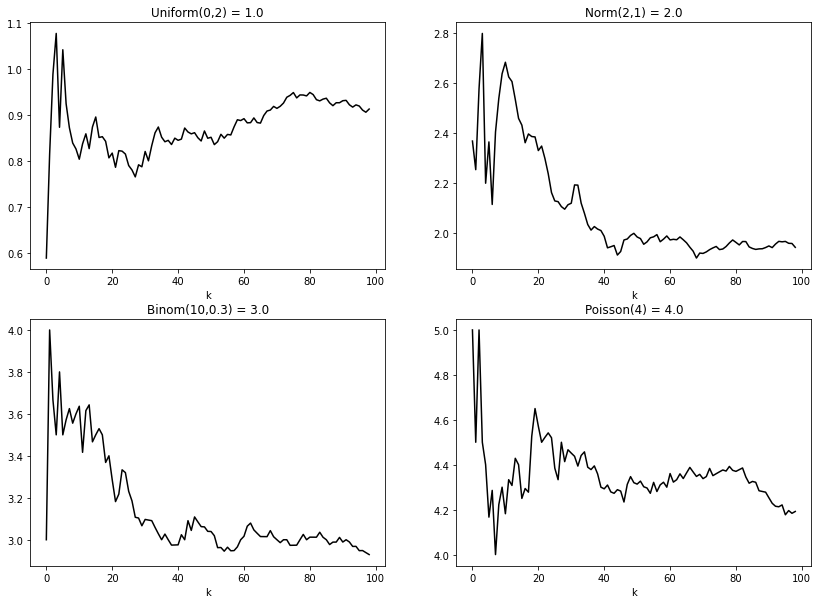

In [2]:
# 大数の法則
n = 100
x = np.zeros((4, 2, n))
for k in range(n):
    x[0,0,k]=sp.stats.uniform.rvs(loc=0,scale=2,size=1)
    x[1,0,k]=sp.stats.norm.rvs(loc=2,scale=1,size=1)
    x[2,0,k]=sp.stats.binom.rvs(n=10,p=0.3,size=1)
    x[3,0,k]=sp.stats.poisson.rvs(mu=4,size=1)
    for i in range(4):
        if k >= 1: x[i,1,k]=np.mean(x[i,0,0:k])

fig,ax = plt.subplots(nrows=2, ncols=2, figsize=(14,10))
titles=['Uniform(0,2) = 1.0','Norm(2,1) = 2.0','Binom(10,0.3) = 3.0','Poisson(4) = 4.0']
for i in range(4):
    col=i//2
    row=i%2
    ax[col, row].plot(x[i,1,1:], color='k')
    ax[col, row].set_xlabel('k')
    ax[col, row].set_title(titles[i])
plt.show()

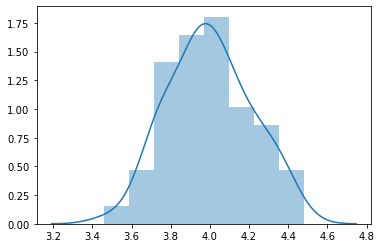

In [5]:
# 中心極限定理
poisson_means = [np.mean(sp.stats.poisson.rvs(mu = 4, size = 100)) for x in range(100)]
sns.distplot(poisson_means)

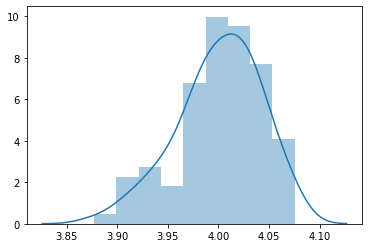

In [3]:
poisson_means = [np.mean(sp.stats.poisson.rvs(mu = 4, size = 2000)) for x in range(100)]
sns.distplot(poisson_means)

# random walk

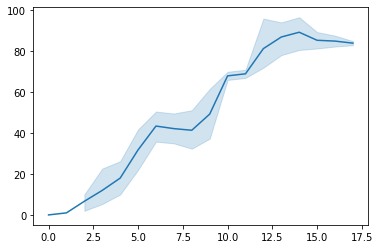

In [30]:
n = 100
p = 0.6
s = np.zeros(n+1)
for k in range(1, n+1):
    dx = 1 if np.random.rand()<p else -1
    s[k]=s[k-1]+dx
sns.lineplot(x=s,y=list(range(n+1)))

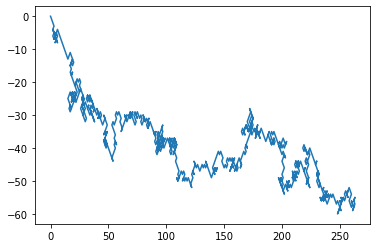

In [87]:
n = 2**10
p1 = [0.25, 0.25, 0.25, 0.25]
p2 = [0.2, 0.3, 0.2, 0.3]
move = np.array([[-1, 1], [1, 1], [-1, -1], [1, -1]])
x = np.zeros(n+1)
y = np.zeros(n+1)
for k in range(1, n+1):
    d = np.random.choice(a = len(p1), p = p2)
    x[k] = x[k-1] + move[d][0]
    y[k] = y[k-1] + move[d][1]
plt.plot(x, y)

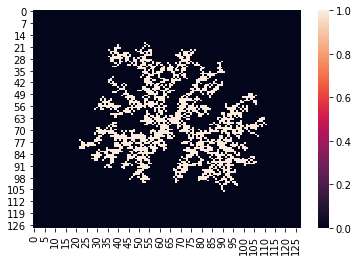

In [23]:
# DLA(Diffusion-Limited Aggregation)
width = 128
center = int(width / 2)
field = np.zeros((width, width))
field[center, center] = 1

N = 2048
for i in range(N):
    x, y = np.random.randint(0, width, size=2)
    if field[x, y] > 0:
        continue
    while True:
        nx = x + np.random.randint(-1, 2)
        ny = y + np.random.randint(-1, 2)
        if nx < 0:
            nx += width
        elif nx >= width:
            nx -= width
        if ny < 0:
            ny += width
        elif ny >= width:
            ny -= width
        
        if field[nx, ny] > 0:
            field[x, y] = 1
            break
        else:
            x = nx
            y = ny
sns.heatmap(field)

# マルコフ連鎖

> πP = π を満たす分布πが存在するとき、これを定常分布という
> ...ある時刻kにおいて次を意味する。 w(k) = w(k+1) すなわち、どれだけ遷移しても、状態の確率分布は変わらない

In [89]:
## Monte Carlo method
N = 10**6
xx, yy = np.random.uniform(-1, 1, size = (2, N))
inside = (xx**2 + yy**2) <= 1
pi = inside.sum() * (4 / np.float(N))
pi

3.1416239999999998

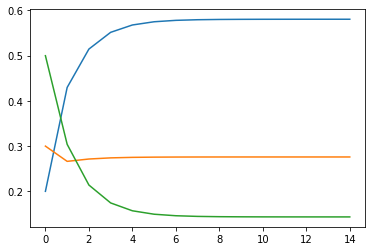

In [42]:
## 
weather = [0,0,2,1,0,0,0,0,1,0,0,1,2,2,2,0,1,1,0,1,0,0,0,0,0,0,0,0,1,1] # 観測
P = np.array([ # 遷移行列
    [12/18, 5/18, 1/18],
    [4/7, 2/7, 1/7],
    [1/4, 1/4, 2/4]
])

Num = 15
w0 = np.array([0.2, 0.3, 0.5]) # 確率分布の初期値
wTrack = np.zeros((3, Num))
wTrack[:, 0] = w0
wK = w0
for k in range(1, Num):
    wK = wK.dot(P) # wK * P = wK+1
    wTrack[:, k] = wK

# 確率分布の初期値を変えても収束値は同じ
xx = np.arange(0, Num, 1.0)
plt.plot(xx, wTrack[0, :])
plt.plot(xx, wTrack[1, :])
plt.plot(xx, wTrack[2, :])

In [31]:
# > ...これは固有値問題で良く用いられる表現 Ax = λx と同じ形式
# > ...（πP = π）はその固有値が１の場合とみなせる
from numpy import linalg

PP = P.T
vals, vecs = np.linalg.eig(PP) # 固有値、固有ベクトル
idx = np.argmax(np.abs(np.real(vals))) # 固有値最大（＝１）計算誤差で虚数となることがあるため実部を取る
pi = np.real(vecs[:, idx]).T # 固有値１の固有ベクトル
pi / np.sum(pi) # を正規化

array([0.58064516, 0.27598566, 0.14336918])

In [38]:
# 連立一次方程式で解く形
A = (P - np.eye(3)).T
A0 = np.ones((4,4)) # ダミー変数π3を追加するため次元を上げる
for i in range(3):
    for j in range(3):
        A0[i,j] = A[i,j]
A0[3,3] = 0

b0 = np.array([0,0,0,1])
np.linalg.solve(A0, b0) # π0+π1+π2 = 1 (π3 = 0)

array([5.80645161e-01, 2.75985663e-01, 1.43369176e-01, 4.62592927e-18])

# wiener過程
1. w(0) = 0
2. 0 <= s < t の時、増分W(t) - w(s)が独立かつ ~N(0, t-s)
3. 標本過程は確率１で連続

いたるところで微分不可能 -> 確率微分方程式  
dx(t) = μ(x(t), t)Δt + σ(x(t), t)Δw(t) // ドリフト項＋拡散項

In [44]:
np.cumsum([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

array([ 1,  3,  6, 10, 15, 21, 28, 36, 45, 55], dtype=int32)

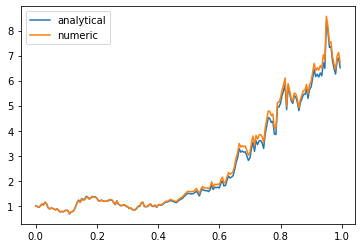

In [62]:
# geometric Bronnian motion
# dx(t) = μx(t) + σx(t)dw(t)
mu, sigma = 2, 1
x0 = 1
tend = 1.0
num = 200
dt = tend/num
# > ここでdtを小さくすれば解の精度は上がると考えるかも...確率系の場合そうはいかない。
# > ...発生の仕方でその標本過程が異なるため、解析解と数値解が一致することはなく、解の考察は何らかの統計量を通して

t = np.arange(0, tend, dt)
dw = sp.stats.norm.rvs(loc = 0, scale = np.sqrt(dt), size = num) # 増分は正規分布に従う
dw[0] = 0
w = np.cumsum(dw) # w(k) = w(k-1) + dw(k) = Σdw(i) + dw(k)
x_true = x0 * np.exp( (mu - (sigma**2) / 2.0)*t + (sigma*w) ) # 一般には解析解を求めるのは困難

xt = x0
x_data = np.zeros(num)
x_data[0] = x0
for k in range(1, num):
    xt += mu * xt * dt + sigma * xt * dw[k] # μx(t) + σx(t)dw(t)
    x_data[k] = xt

plt.plot(t, x_true, label="analytical")
plt.plot(t, x_data, label="numeric")
plt.legend()

# カルマンフィルタ

## 状態空間モデル
```
x(k + 1) = A*x(k) + b*v(k)
y(k) = c.T * x(k) + w(k)

k : 離散時刻

x : 状態変数 観測できない
v : システムノイズ ~N
b : 駆動ベクトル システムノイズを状態変数へ
A : システム行列

y : 観測値
w : 観測ノイズ ~N
c : 観測ベクトル 状態変数から観測値へ変換する
```

In [11]:
# System Information
a, b, c = 1, 1, 1
sigma_v = 1.0
sigma_w = np.sqrt(2.0)
num = 500

# 系列を生成
x = 0.0
x_data = np.zeros(num)
y_data = np.zeros(num)
x_data[0] = x
for k in range(num):
    x = a*x + sp.stats.norm.rvs(loc = 0, scale = sigma_v, size = 1)
    y = c*x + sp.stats.norm.rvs(loc = 0, scale = sigma_w, size = 1)
    x_data[k] = x # 状態変数
    y_data[k] = y # 観測値

# カルマンフィルタ
xhat = 0.0
P = 0.001
xhat_data = np.zeros(num)
xhat_data[0] = xhat
for k in range(num):
    # １ステップの予測
    xhat = a * xhat # 予測値 ^x(k|k-1) = a * x^(k-1|k-1)
    P = a*P*a + (sigma_v**2)*(b*b) # 事前誤差共分散行列 P(k|k-1) = A * P(k-1|k-1) * A + σv*b*b 
    # フィルタリング
    g = P*c / (c*P*c + sigma_w**2) # カルマンゲイン g(k) = P(k)*c / (c*P(k)*c + σw**2)
    xhat = xhat + g*(y_data[k] - c*xhat) # 予測値をフィルタ x^(k|k) = x^(k) + g(k)*(y(k) - c*xhat(k))
    P = (1 - g*c) * P # 事後誤差共分散行列 P(k|k) = (I - g(k)*c) * P(k)
    xhat_data[k] = xhat

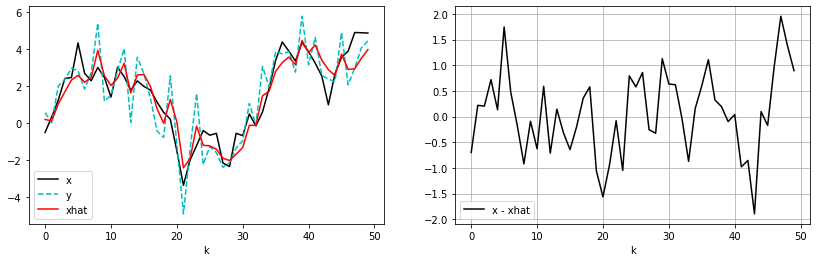

In [12]:
fig, ax = plt.subplots(ncols=2, figsize=(14,4))

nn = 50
# > カルマンフィルタと言えどもローパスフィルタのような位相遅れは避けられないが、予測を行うため位相遅れを低減している
ax[0].plot(x_data[:nn], c='k', label='x')
ax[0].plot(y_data[:nn], c='c', label='y', linestyle='dashed')
ax[0].plot(xhat_data[:nn], c='r', label='xhat')
ax[0].set_xlabel('k')
ax[0].legend()
# > この残差を評価するには分散の値を見る。または正規性の検定などの方法が採用される
ax[1].plot( (x_data[:nn]-xhat_data[:nn]), c='k', label='x - xhat')
ax[1].set_xlabel('k')
ax[1].legend()
ax[1].grid()